<a href="https://colab.research.google.com/github/dungdt-infopstats/TV-command-synthesis/blob/main/notebooks/WER_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

tridungdo_ddss_aug_ratio_test_path = kagglehub.dataset_download('tridungdo/ddss-aug-ratio-test')
tridungdo_wer_ratio_analysis_dataset_path = kagglehub.dataset_download('tridungdo/wer-ratio-analysis-dataset')

print('Data source import complete.')


In [ ]:
import pandas as pd

df_wer = pd.read_csv("/kaggle/input/wer-ratio-analysis-dataset/asr_evaluation_results.csv", sep = ',')

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.6 MB/s eta 0:00:0000:0100:01


In [ ]:
import unicodedata
import re
from typing import Dict, Any
import jiwer
import numpy as np

# ----------------------
# Normalize text
# ----------------------
def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize("NFD", text)
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ----------------------
# WER computation
# ----------------------
def levenshtein_alignment(ref: str, hyp: str) -> Dict[str, Any]:
    try:
        ref = ref.strip() if ref else ""
        hyp = hyp.strip() if hyp else ""

        if not ref and not hyp:
            return {"wer": 0.0, "S": 0, "D": 0, "I": 0, "N": 0}
        elif not ref:
            return {"wer": 1.0, "S": 0, "D": 0, "I": len(hyp.split()), "N": 0}
        elif not hyp:
            return {"wer": 1.0, "S": 0, "D": len(ref.split()), "I": 0, "N": len(ref.split())}

        wer_score = jiwer.wer(ref, hyp)
        measures = jiwer.process_words(ref, hyp)

        return {
            "wer": wer_score,
            "S": measures.substitutions,
            "D": measures.deletions,
            "I": measures.insertions,
            "N": measures.hits + measures.substitutions + measures.deletions,
        }
    except Exception as e:
        print(f"Error in WER computation for ref='{ref}', hyp='{hyp}': {e}")
        return {
            "wer": 1.0,
            "S": 0,
            "D": len(ref.split()) if ref else 0,
            "I": len(hyp.split()) if hyp else 0,
            "N": len(ref.split()) if ref else 0,
        }

# ----------------------
# CER computation
# ----------------------
def levenshtein_alignment_cer(ref: str, hyp: str) -> Dict[str, Any]:
    try:
        ref = ref.strip() if ref else ""
        hyp = hyp.strip() if hyp else ""

        if not ref and not hyp:
            return {"cer": 0.0, "S": 0, "D": 0, "I": 0, "N": 0}
        elif not ref:
            return {"cer": 1.0, "S": 0, "D": 0, "I": len(hyp), "N": 0}
        elif not hyp:
            return {"cer": 1.0, "S": 0, "D": len(ref), "I": 0, "N": len(ref)}

        import editdistance
        dist = editdistance.eval(ref, hyp)

        N = len(ref)
        if len(ref) == len(hyp):
            S, D, I = dist, 0, 0
        elif len(ref) > len(hyp):
            D = len(ref) - len(hyp)
            S = max(dist - D, 0)
            I = 0
        else:
            I = len(hyp) - len(ref)
            S = max(dist - I, 0)
            D = 0

        return {
            "cer": dist / N,
            "S": S,
            "D": D,
            "I": I,
            "N": N,
        }
    except Exception as e:
        print(f"Error in CER computation for ref='{ref}', hyp='{hyp}': {e}")
        return {
            "cer": 1.0,
            "S": 0,
            "D": len(ref) if ref else 0,
            "I": len(hyp) if hyp else 0,
            "N": len(ref) if ref else 0,
        }

# ----------------------
# Luồng xử lý DataFrame
# ----------------------
def process_row(row):
    ref_text = row.get("reference_text", "")
    hyp_text = row.get("recognized_text", "")

    hyp = normalize_text(hyp_text)
    ref = normalize_text(ref_text)

    wer_metrics = levenshtein_alignment(ref, hyp)
    cer_metrics = levenshtein_alignment_cer(ref, hyp)

    row["recognized_text_norm"] = hyp
    row["reference_text_norm"] = ref

    # update WER metrics
    row.update(wer_metrics)
    # update CER metrics (prefix "c")
    row.update({f"c{k}": v for k, v in cer_metrics.items()})

    # thêm rate
    N = wer_metrics["N"] if wer_metrics["N"] > 0 else np.nan
    row["S_rate"] = wer_metrics["S"] / N if N else 0
    row["D_rate"] = wer_metrics["D"] / N if N else 0
    row["I_rate"] = wer_metrics["I"] / N if N else 0

    cN = cer_metrics["N"] if cer_metrics["N"] > 0 else np.nan
    row["cS_rate"] = cer_metrics["S"] / cN if cN else 0
    row["cD_rate"] = cer_metrics["D"] / cN if cN else 0
    row["cI_rate"] = cer_metrics["I"] / cN if cN else 0

    return row

df_wer_new = df_wer.apply(process_row, axis=1)

In [ ]:
deep_ana = df_wer_new[['id_x', 'id_f', 'recognized_text', 'reference_text', 'wer', 'S_rate', 'D_rate', 'I_rate', 'snr_db', 'mode', 'snr_range']]

In [ ]:
deep_ana.loc[:, "type"] = deep_ana['id_f'].str.rsplit('_', n=1).str.get(0)

/tmp/ipykernel_36/2889590079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep_ana.loc[:, "type"] = deep_ana['id_f'].str.rsplit('_', n=1).str.get(0)


In [ ]:
deep_ana.describe()

,wer,S_rate,D_rate,I_rate,snr_db
count,19830.000000,16019.000000,16019.000000,16019.000000,19830.000000
mean,0.540555,0.142894,0.359252,0.135673,7.453977
std,0.557531,0.241497,0.403609,0.424313,7.228296
min,0.000000,0.000000,0.000000,0.000000,-4.997860
25%,0.000000,0.000000,0.000000,0.000000,1.215459
50%,0.500000,0.000000,0.142857,0.000000,7.448064
75%,1.000000,0.200000,0.785714,0.000000,13.660855
max,13.000000,1.000000,1.000000,12.000000,19.999526


/tmp/ipykernel_36/1619784095.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df.groupby(group_col)['D_rate'].mean()       # mean
/tmp/ipykernel_36/1619784095.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df.groupby(group_col)['D_rate'].mean()       # mean
/tmp/ipykernel_36/1619784095.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df.groupby(group_col)['D_rate'].mean()

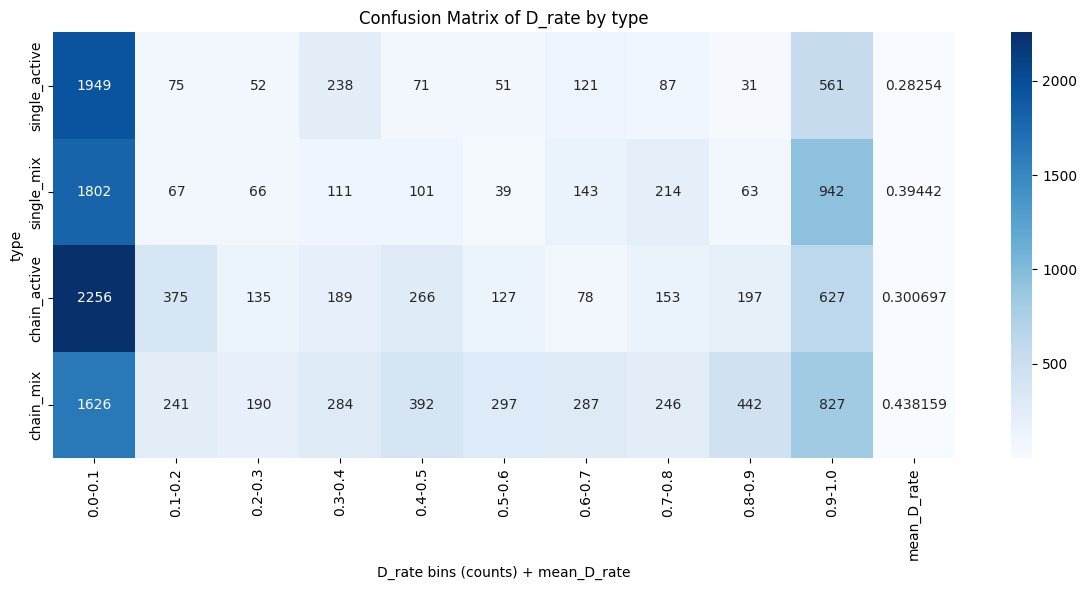

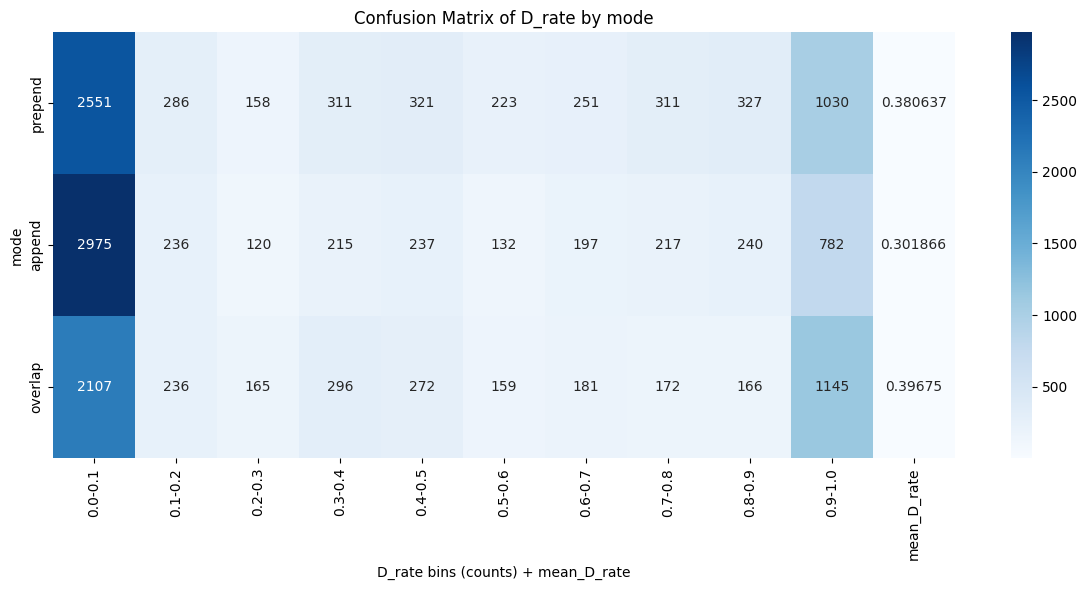

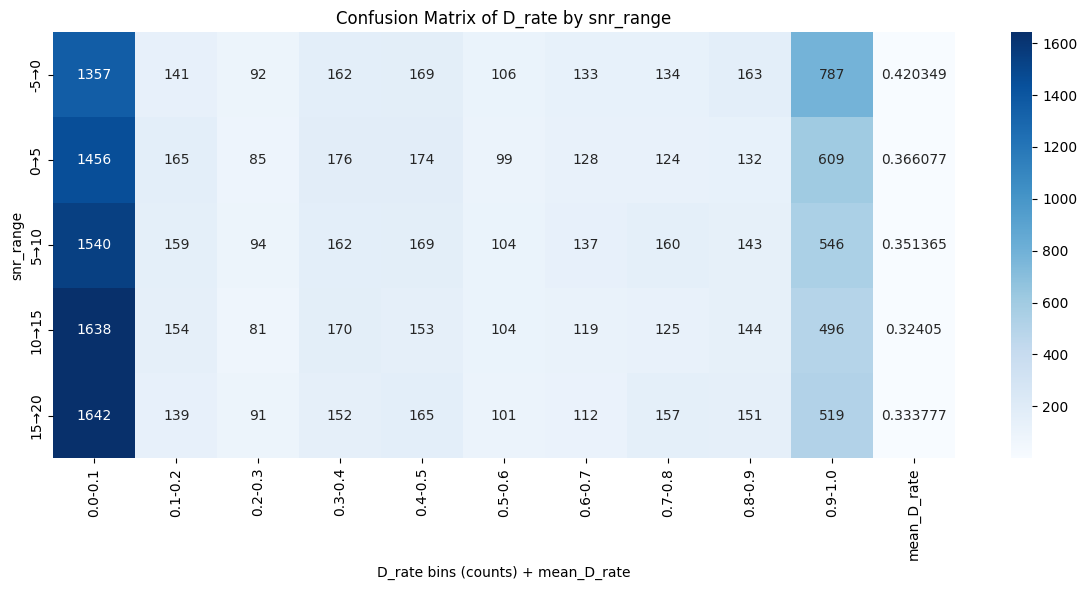

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- giả sử deep_ana đã tồn tại ---
deep_ana = df_wer_new.copy()   # tránh SettingWithCopyWarning

# Chia D_rate thành 10 bins từ 0 đến 1
bins = np.linspace(0, 1, 11)  # 0, 0.1, ..., 1.0
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

deep_ana.loc[:, 'D_rate_bin'] = pd.cut(
    deep_ana['D_rate'], bins=bins, labels=labels, include_lowest=True
)

# --- Config thứ tự category ---
TYPE_ORDER = ["single_active", "single_mix", "chain_active", "chain_mix", "non_active"]
MODE_ORDER = ["prepend", "append", "overlap"]
SNR_ORDER  = ["-5→0", "0→5", "5→10", "10→15", "15→20"]

# ép cột thành categorical để giữ đúng thứ tự
deep_ana['type'] = pd.Categorical(deep_ana['type'], categories=TYPE_ORDER, ordered=True)
deep_ana['mode'] = pd.Categorical(deep_ana['mode'], categories=MODE_ORDER, ordered=True)
deep_ana['snr_range'] = pd.Categorical(deep_ana['snr_range'], categories=SNR_ORDER, ordered=True)

# --- Tạo confusion matrix + mean ---
def make_matrix(df, group_col):
    cm = pd.crosstab(df[group_col], df['D_rate_bin'])        # count
    mean_vals = df.groupby(group_col)['D_rate'].mean()       # mean
    cm['mean_D_rate'] = mean_vals                            # thêm cột mean
    return cm

cm_type = make_matrix(deep_ana, 'type')
cm_mode = make_matrix(deep_ana, 'mode')
cm_snr  = make_matrix(deep_ana, 'snr_range')

# --- Plot function ---
def plot_heatmap(df, title):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df, annot=True, fmt="g", cmap="Blues")
    plt.title(title)
    plt.ylabel(df.index.name)
    plt.xlabel("D_rate bins (counts) + mean_D_rate")
    plt.tight_layout()
    plt.show()

# --- Vẽ heatmap ---
plot_heatmap(cm_type, "Confusion Matrix of D_rate by type")
plot_heatmap(cm_mode, "Confusion Matrix of D_rate by mode")
plot_heatmap(cm_snr, "Confusion Matrix of D_rate by snr_range")
